In [1]:
!pip3 install beautifulsoup4 --user
!pip3 install metar --user
!pip3 install -q -U tqdm --user
!pip3 install -q -U https://github.com/matplotlib/basemap/archive/master.zip --user
!pip3 install portolan --user
!pip3 install pandas --user

  Using cached https://files.pythonhosted.org/packages/26/8c/1da0580f334718e04f8bbf74f0515a7fb8185ff96b2560ce080c11aa145b/pyproj-1.9.6.tar.gz
  Found existing installation: pyproj 2.6.1.post1
    Uninstalling pyproj-2.6.1.post1:
      Successfully uninstalled pyproj-2.6.1.post1
  Running setup.py install for pyproj ... done


In [12]:
import os
import re
import shutil
import datetime
import multiprocessing
from datetime import date, timedelta
from calendar import monthrange

from urllib.request import urlopen
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from metar import Metar

import portolan

path = os.path.abspath(os.getcwd())

# Fetch observations

In [13]:
def fetch(url):
    try:
        html = urlopen(url).read()
        soup = BeautifulSoup(html, features='html.parser')
        for script in soup(["script", "style"]):
            script.extract()
        return soup
    except Exception:
        return None

def get_all_metar_obs(icao, year, month):
    now = datetime.datetime.utcnow()
    if month == now.month:
        url = f"https://www.ogimet.com/display_metars2.php?lang=en&lugar={icao}&tipo=SA&ord=DIR&nil=NO&fmt=txt&ano={year}&mes={month}&day={now.day+1}&hora={now.hour}&min=00&anof=2020&mesf={month}&dayf={now.day}&horaf={now.hour}&minf=59"
    else:
        url = f"https://www.ogimet.com/display_metars2.php?lang=en&lugar={icao}&tipo=SA&ord=DIR&nil=NO&fmt=txt&ano={year}&mes={month}&day=1&hora=00&min=00&anof=2020&mesf={month}&dayf={monthrange(year, month)[1]}&horaf=23&minf=59"
    soup = fetch(url)
    if soup is None:
        return []
    text = soup.get_text()
    if f"No hay METAR/SPECI de {station} en el periodo solicitado" in text:
        return []
    data = []
    text = re.sub('\s\s+', ' ', text)
    matches = re.findall(r"\s(\d+)[\s]METAR\s(.*)=", text)
    for match in matches:
        if ',' not in match:
            data.append({ 'datetime': match[0], 'observation': match[1] })
    return data

# Parse data from METAR

In [14]:
def get_pressure(obs):
    """returns press Pa
    
    format examples:
        pressure: 1027.8 mb
        3-hr pressure change 1.7hPa, increasing, then decreasing
    """

    press = 0.0
    if 'pressure:' in obs:
        press = float(re.findall(r".*pressure:\s(.*)[\s]mb\s*", obs)[0])
    else:
        press = float(re.findall(r".*pressure[\s]change[\s](.*)hPa", obs)[0])

    return press * 100

def get_dew_point(obs):
    """ returns temp K """
    return float(re.findall(r".*dew[\s]point:\s(.*)[\s]C\s*", obs)[0]) + 273.15

def get_temperature(obs):
    """ returns temp K """
    return float(re.findall(r".*temperature:\s(.*)[\s]C\s*", obs)[0]) + 273.15

def nearest_neighbour(X_lng, Y_lat, lng, lat):
    diff_x = 100
    diff_y = 100
    pos_x = 0
    pos_y = 0
    for x in X_lng:
        diff = abs(x - lng)
        if diff_x > diff:
            pos_x = x
            diff_x = diff

    for y in Y_lat:
        diff = abs(y - lat)
        if diff_y > diff:
            pos_y = y
            diff_y = diff
    return (pos_x, pos_y)

# Physical formulas

In [15]:
def vapor_pressure(T):
    """Return partial water vapor pressure (e) or saturation vapor pressure (es) hPa.
    
    dew_point for (e) K
    temperature for (es) K
    more info: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    alternatives: August–Roche–Magnus formula
    """
    a = 17.2693882
    b = 35.86
    e = 6.1078 * np.exp(a * (T - 273.16) / (T - b))
    
    return e

def calculate_shum(dew_point, pressure):
    """Return specific humidity kg/kg.
    
    dew_point K
    pressure  Pa
    more info: https://cran.r-project.org/web/packages/humidity/vignettes/humidity-measures.html
    """
    e = vapor_pressure(dew_point)
    q = 0.622 * e  / (pressure - 0.378 * e)
    
    #print(dew_point, pressure, q)    
    return q

def calculate_rhum(dew_point, temp):
    """ validator: https://www.wpc.ncep.noaa.gov/html/dewrh.shtml """
    rhum = 100 * vapor_pressure(dew_point) / vapor_pressure(temp)

    #print(dew_point, temp, rhum)
    return rhum

# Multiprocessing METARs fetching

In [16]:
station = 'SKBQ'
dates = pd.date_range(start='2014-01-01',end='2020-10-31', freq='MS')

def get_metars_from_date(date):
    localdata = []
    metar_obs = get_all_metar_obs(station, date.year, date.month)
    for obs_item in metar_obs:
        hour = datetime.datetime.strptime(obs_item['datetime'], '%Y%m%d%H%M').hour
        if hour == 0 or hour == 6 or hour == 12 or hour == 18:
            localdata.append([obs_item['datetime'], obs_item['observation']])
        
    return localdata

In [17]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(get_metars_from_date, dates)

df = []
for elem in data:
    for arr in elem:
        df.append(arr)

len(df)

479

In [18]:
df = pd.DataFrame(data=df, columns=['datetime', 'observation'])
df.head(5)

,datetime,observation
0,202007010000,SKBQ 010000Z 34009KT 310V010 CAVOK 28/24 A2979...
1,202007010600,SKBQ 010600Z 34004KT 300V010 9999 FEW012 BKN20...
2,202007011200,SKBQ 011200Z 00000KT 6000 VCFG SCT010 SCT200 2...
3,202007011800,SKBQ 011800Z 00000KT 9999 SCT015TCU SCT200 33/...
4,202007020000,SKBQ 020000Z 36007KT 9999 SCT015 27/24 A2980 N...


In [12]:
idx = 0
row = df.iloc[idx]
obs = Metar.Metar(row['observation']).string()
print(obs)

station: PADK
type: routine report, cycle 1 (automatic report)
time: Sun Nov  1 00:56:00 2020
temperature: 13.3 C
dew point: 7.2 C
wind: W at 11 knots, gusting to 18 knots
visibility: 10 miles
pressure: 1018.3 mb
sky: a few clouds at 2200 feet
     broken clouds at 3600 feet
     broken clouds at 4400 feet
sea-level pressure: 1018.2 mb
remarks:
- Automated station (type 2)
METAR: PADK 010056Z AUTO 26011G18KT 10SM FEW022 BKN036 BKN044 13/07 A3007 RMK AO2 SLP182 T01330072
51.88333333333333 -176.65 4


In [13]:
df['datetime'] = pd.to_datetime(df.datetime)
df = df.sort_values(by='datetime')

df.head()

,lat,lng,elev,datetime,observation
1432007,4.833333,7.016667,18,2020-09-01,DNPO 010000Z 00000KT 6000 BKN007 23/22 Q1013 N...
932301,54.283333,-130.416667,34,2020-09-01,CYPR 010000Z AUTO 18003KT 120V210 3SM -RA BR O...
932555,49.466667,-120.516667,700,2020-09-01,CYDC 010000Z 35005KT 290V080 25SM FEW084 BKN09...
1648791,-25.183333,130.983333,496,2020-09-01,YAYE 010000Z AUTO 10005KT 9999 // NCD 20/03 Q1019
932675,53.016667,-122.516667,545,2020-09-01,CYQZ 010000Z AUTO 15008G17KT 9SM SCT050 OVC075...


In [14]:
def parse_metars(idx):
    dt = []
    row = df.iloc[idx]
    try:
        temp = 0.0
        obs = Metar.Metar(row['observation']).string()
        if ('temperature' in obs):
            temp = get_temperature(obs)
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), 'air', temp])

        if ('pressure' in obs):
            press = get_pressure(obs)
            dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), 'press', press])

        if ('dew point' in obs and 'pressure' in obs):
            dew_point = get_dew_point(obs)
            if dew_point > 0 and press < 105100 and press > 52200 and dew_point <= temp and temp != 0 :
                shum = calculate_shum(dew_point, press)
                rhum = calculate_rhum(dew_point, temp)
                dt.append([row['datetime'].strftime("%Y-%m-%d %H:%M:%S"), 'rhum', rhum])
    except Exception as e:
        str_err = str(e)
        if 'Unparsed groups' not in str_err and '_handleTime' not in str_err and '_handleWind' not in str_err and "NSW" not in str_err:
            print('index:', idx, 'error:', e)
    return dt

In [15]:
jobs = multiprocessing.cpu_count()
with multiprocessing.Pool(jobs - 1) as p:
    data = p.map(parse_metars, range(len(df)))
    
df_parsed_metars = []
active_stations = []
for elem in data:
    df_parsed_metars += elem[0]

print(f"total metars: {len(df_parsed_metars)}")

index: 647297 error: '--'
total metars: 9085793, active stations: 5169


In [19]:
df_metar_info = pd.DataFrame(df_parsed_metars,columns=['datetime','variable','value'])

df_metar_info.head(10)

,datetime,lat,lng,elev,variable,value
0,2020-09-01 00:00:00,4.833333,7.016667,18,air,296.150000
1,2020-09-01 00:00:00,4.833333,7.016667,18,press,101300.000000
2,2020-09-01 00:00:00,4.833333,7.016667,18,rhum,94.108675
3,2020-09-01 00:00:00,4.833333,7.016667,18,shum,0.000162
4,2020-09-01 00:00:00,54.283333,-130.416667,34,air,287.150000
5,2020-09-01 00:00:00,54.283333,-130.416667,34,uwnd,-0.867965
6,2020-09-01 00:00:00,54.283333,-130.416667,34,vwnd,1.275983
7,2020-09-01 00:00:00,54.283333,-130.416667,34,press,101660.000000
8,2020-09-01 00:00:00,54.283333,-130.416667,34,rhum,100.000000
9,2020-09-01 00:00:00,54.283333,-130.416667,34,shum,0.000098


In [20]:
all_df_datetimes = []

for df_datetime in df_metar_info.datetime.unique():
    parsed_datetime = datetime.datetime.strptime(df_datetime, '%Y-%m-%d %H:%M:%S')
    if parsed_datetime.minute == 0:
        all_df_datetimes.append(parsed_datetime)

count    1.629425e+06
mean     8.743684e-05
std      4.807916e-05
min      4.166641e-08
25%      5.049711e-05
50%      7.609896e-05
75%      1.178573e-04
max      6.247101e-03
Name: value, dtype: float64

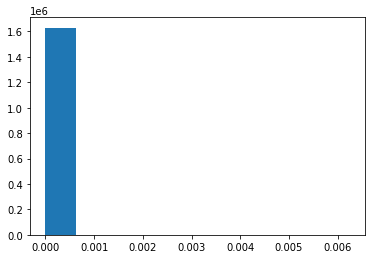

In [22]:
data = df_metar_info.loc[df_metar_info['variable']=='press']['value']
plt.hist(data)
data.describe()

count    1.629425e+06
mean     7.112938e+01
std      2.346850e+01
min      1.611422e-02
25%      5.613871e+01
50%      7.680475e+01
75%      9.007311e+01
max      1.000000e+02
Name: value, dtype: float64

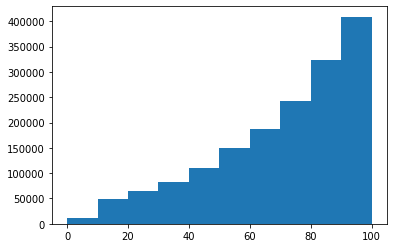

In [23]:
data = df_metar_info.loc[df_metar_info['variable']=='rhum']['value']
plt.hist(data)
data.describe()

count    1.642433e+06
mean     2.897757e+02
std      9.053015e+00
min      2.120500e+02
25%      2.837500e+02
50%      2.901500e+02
75%      2.966500e+02
max      3.251500e+02
Name: value, dtype: float64

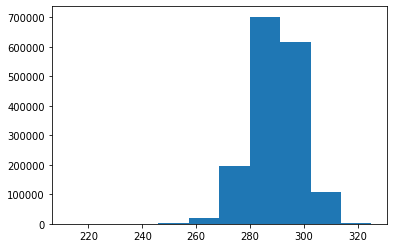

In [25]:
data = df_metar_info.loc[df_metar_info['variable']=='air']['value']
plt.hist(data)
data.describe()

In [28]:
store = pd.HDFStore('data.h5')
store['df'] = df_metar_info